## Imports

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.linear_model import LinearRegression

import tensorflow as tf

import os

In [9]:
np.set_printoptions(suppress=True)

['.DS_Store', 'analysis_notebook.ipynb', 'BDA_Project_Template.pdf', 'data']


## Data Preparation

In [40]:
# Import the data
data = pd.read_csv("data/mental_health_analysis.csv")

In [50]:
list(data.columns)

['User_ID',
 'Age',
 'Gender',
 'Social_Media_Hours',
 'Exercise_Hours',
 'Sleep_Hours',
 'Screen_Time_Hours',
 'Survey_Stress_Score',
 'Wearable_Stress_Score',
 'Support_System',
 'Academic_Performance']

In [41]:
# Assert that there are no NAs
assert(data.isna().sum().sum() == 0)

## Data Summary Statistics

In [42]:
# Basic summary
summary = data.describe()

# Add MADs
sum_columns = summary.columns
mads = [np.median(np.abs(base_data[column] - base_data[column].median())) for column in sum_columns]

summary.loc['mad'] = mads

# Formatting
summary = round(summary, 3)


In [43]:
# Display summary
summary

,User_ID,Age,Social_Media_Hours,Exercise_Hours,Sleep_Hours,Screen_Time_Hours,Survey_Stress_Score,Wearable_Stress_Score
count,5000.00,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000
mean,2500.50,15.493,4.932,1.498,7.057,7.069,3.016,0.497
std,1443.52,1.715,2.854,0.874,1.722,2.883,1.415,0.290
min,1.00,13.000,0.001,0.000,4.002,2.000,1.000,0.000
25%,1250.75,14.000,2.473,0.734,5.612,4.574,2.000,0.245
50%,2500.50,16.000,4.898,1.483,7.069,7.119,3.000,0.500
75%,3750.25,17.000,7.369,2.276,8.519,9.526,4.000,0.750
max,5000.00,18.000,9.995,3.000,9.999,11.999,5.000,1.000
mad,1250.00,1.000,2.443,0.773,1.454,2.484,1.000,0.252


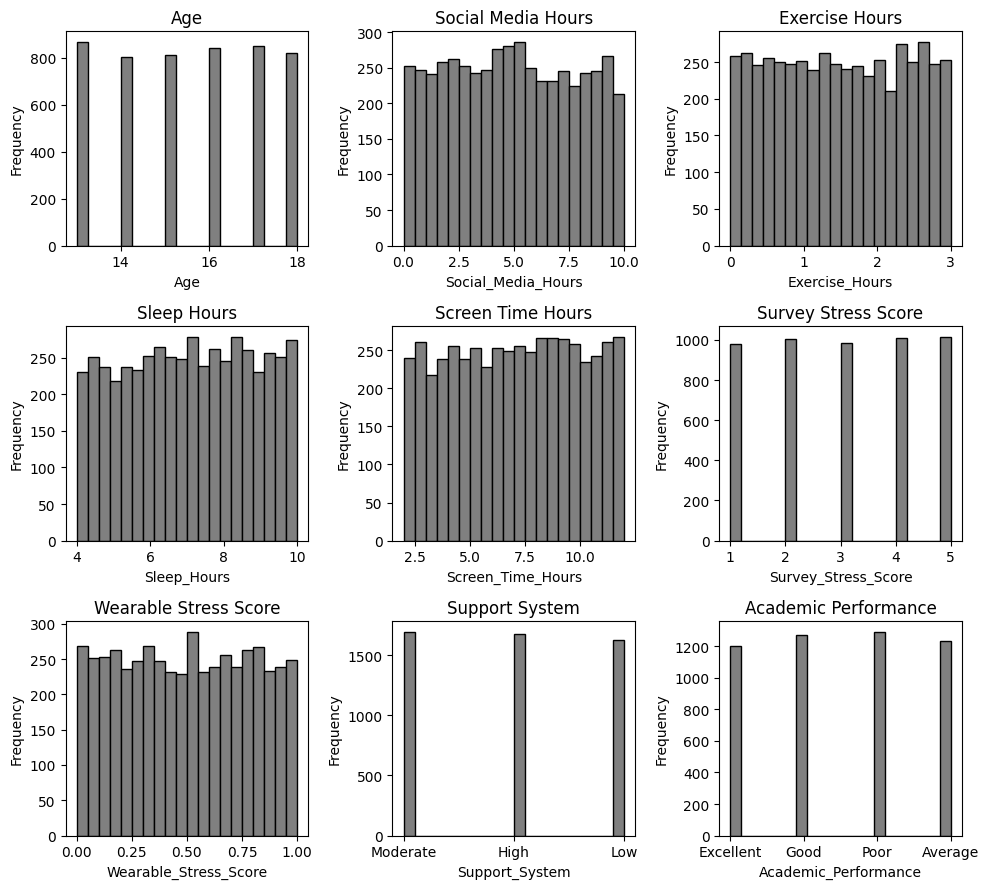

In [54]:
# Set number of columns in the grid
data_to_plot = data[list(filter(lambda x: x not in ["User_ID", "Gender"], data.columns))]
n_cols = 3
n_rows = int(np.ceil(len(data_to_plot.columns) / n_cols))

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 3 * n_rows))
axes = axes.flatten()  # Flatten in case it's 2D

# Plot histograms
for i, col in enumerate(data_to_plot.columns):
    axes[i].hist(data_to_plot[col], bins=20, color='grey', edgecolor='black')
    axes[i].set_title(f'{col.replace("_", " ")}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Factor Analysis

### Factor Analysis Fits

### Factor Analysis Evaluations

## Regression Models

### Regression Model Fits

### Regression Model Evaluations